In [1]:
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import Oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_path(cart_path,target,xlim=[-5,5],ylim=[-5,5]):
    path = cart_path[0,:,:]
    target = target[0,:,:]
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.grid()
    plt.show()

In [3]:
print('Sample 1 : check Oplus')
sample_oplus = Oplus()
sample_x1 = Variable(xp.array([[1, 1, 1]], dtype = 'float32'))
sample_x2 = Variable(xp.array([[1, 2, 0]], dtype = 'float32'))
print(sample_x1.shape)
sample_z = sample_oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()


Sample 1 : check Oplus
(1, 3)
variable([[-0.14263976  2.9220755   1.0000002 ]])
variable([[-0.14263976]
          [ 2.9220755 ]
          [ 0.        ]])
variable([[8.558871]])
(1, 1)


Sample 2 : plot Oplus
variable([[1.        0.        0.5235989]])
variable([[1.8660253 0.5000001 1.0471976]])
variable([[2.3660252 1.3660256 1.5707963]])
[[[0.        0.        0.       ]
  [1.        0.        0.5235989]
  [1.8660253 0.5000001 1.0471976]
  [2.3660252 1.3660256 1.5707963]]]


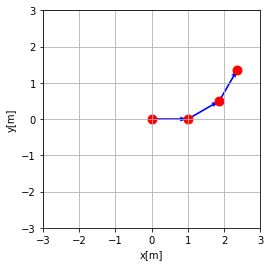

In [4]:
print('Sample 2 : plot Oplus')
sample_oplus = Oplus()
sample_x1 = Variable(xp.array([[0, 0, 0]], dtype = 'float32'))
sample_x2 = Variable(xp.array([[1, 0, xp.pi/6]], dtype = 'float32'))
sample_x3 = Variable(xp.array([[1, 0, xp.pi/6]], dtype = 'float32'))
sample_x4 = Variable(xp.array([[1, 0, xp.pi/6]], dtype = 'float32'))
sample_z1 = sample_oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = sample_oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = sample_oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
pathes = xp.array([xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data))],dtype='float32')
print(pathes)
plot_path(pathes,pathes,[-3,3],[-3,3])

In [5]:
print('Sample 3 : Mini-batch Data')
sample_oplus = Oplus()
# minibatch data
sample_target1 = Variable(xp.array([
    [1., 0., 0.],
    [1., 0., 0.],
    [1., 0., 0.]
    ], dtype='float32'))
sample_target2 = Variable(xp.array([
    [2., 0., 0.],
    [2., 0., 0.],
    [2., 0., 0.]
    ], dtype='float32'))
sample_target3 = Variable(xp.array([
    [3., 0., 0.],
    [3., 0., 0.],
    [3., 0., 0.]
    ], dtype='float32'))
sample_x1 = Variable(xp.array([
    [0., 0., 0.],
    [0., 0., 0.],
    [0., 0., 0.],
    ], dtype = 'float32'))
sample_x2 = Variable(xp.array([
    [1., 0., 0.],
    [1., 0., 0.],
    [.5, 0., 0.]
    ], dtype = 'float32'))
sample_x3 = Variable(xp.array([
    [1., 0., 0.],
    [.5, 0., 0.],
    [.5, 0., 0.]
    ], dtype = 'float32'))
sample_x4 = Variable(xp.array([
    [1, 0., 0.],
    [.5, 0., 0.],
    [.5, 0., 0.]
    ], dtype = 'float32'))
sample_z1 = sample_oplus(sample_x1,sample_x2)
sample_e = F.sqrt(F.sum( (sample_z1-sample_target1)*(sample_z1-sample_target1),axis=1 ))
print(sample_z1)
print(sample_e)
sample_z2 = sample_oplus(sample_z1,sample_x3)
sample_e = sample_e + F.sqrt(F.sum( (sample_z2-sample_target2)*(sample_z2-sample_target2),axis=1 ))
print(sample_z2)
print(sample_e)
print(sample_z2.shape,sample_x4.shape)
sample_z3 = sample_oplus(sample_z2,sample_x4)
sample_e = sample_e + F.sqrt(F.sum( (sample_z3-sample_target3)*(sample_z3-sample_target3),axis=1 ))
print(sample_z3)
print(sample_e)
sample_e.backward()

Sample 3 : Mini-batch Data
variable([[1.  0.  0. ]
          [1.  0.  0. ]
          [0.5 0.  0. ]])
variable([0.  0.  0.5])
variable([[2.  0.  0. ]
          [1.5 0.  0. ]
          [1.  0.  0. ]])
variable([0.  0.5 1.5])
(3, 3) (3, 3)
variable([[3.  0.  0. ]
          [2.  0.  0. ]
          [1.5 0.  0. ]])
variable([0.  1.5 3. ])


In [6]:
# dataset
DATA_SIZE = 1000
DATA_WAYPOINTS = 10
DATA_STEP = DATA_WAYPOINTS
DATA_SPACE = 0.1 # [m / 0.1sec]
X_train = xp.empty((0 ,DATA_WAYPOINTS*2),dtype=xp.float32)
for i in range(DATA_SIZE):
    d = data.make_arc_path_2(int(DATA_WAYPOINTS*DATA_SPACE+1),xp.random.rand()*(2*xp.pi/3)-xp.pi/3) # -60 ~ 60 deg / 0.1m
    d_es,_ = data.get_evenly_spaced_points(d,DATA_SPACE)
    d_xy = d_es[:,0:2]
    d_xy_fl = xp.ravel(d_xy[0:DATA_WAYPOINTS])
    X_train = xp.vstack((X_train,d_xy_fl))
print(X_train.shape)

(1000, 20)


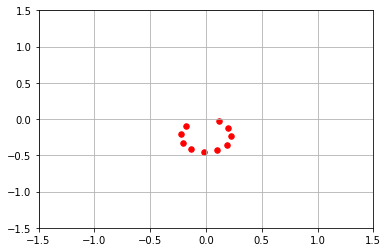

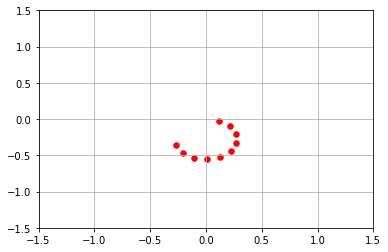

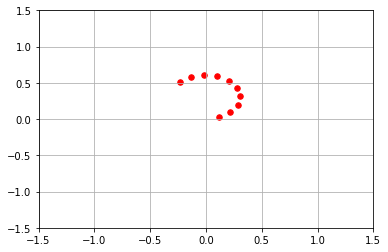

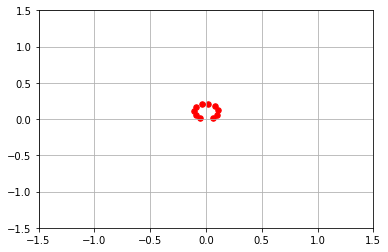

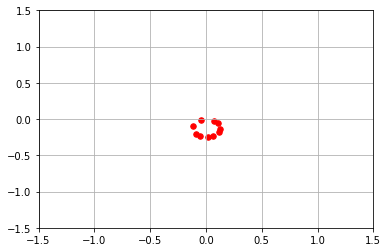

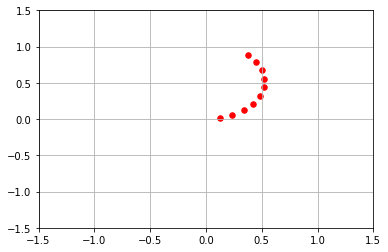

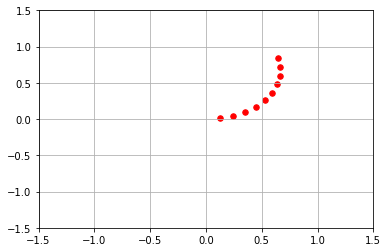

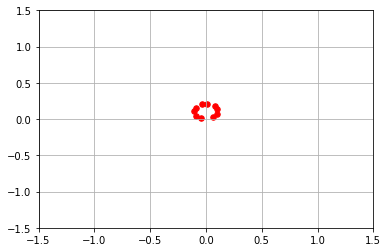

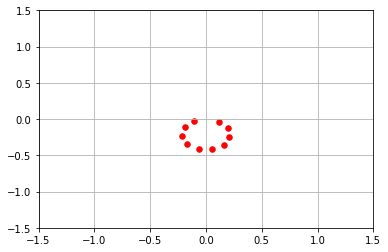

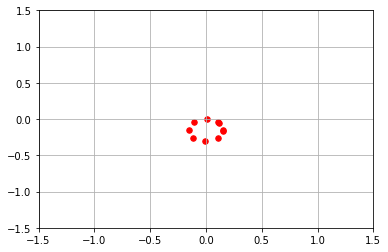

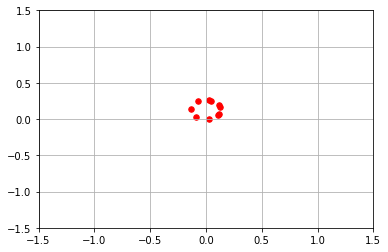

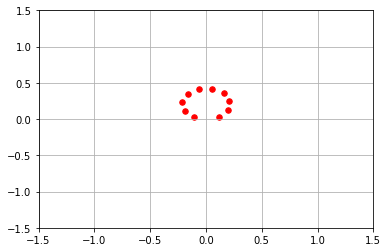

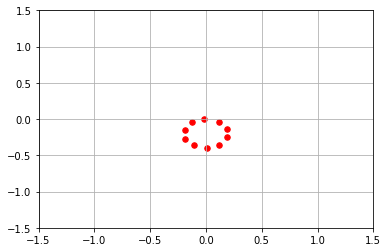

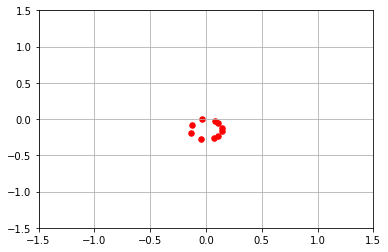

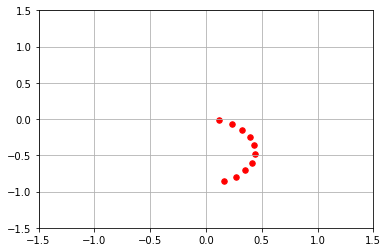

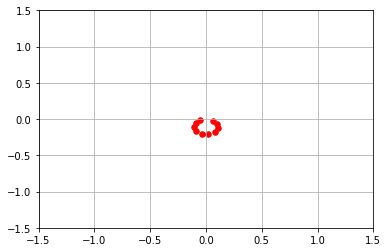

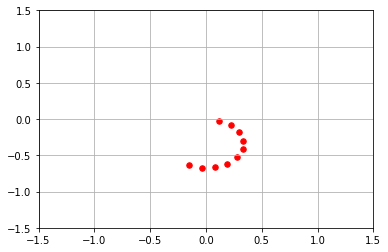

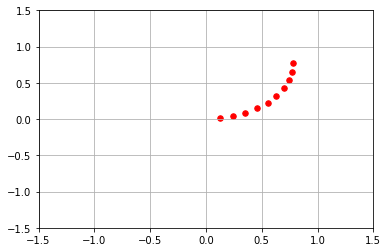

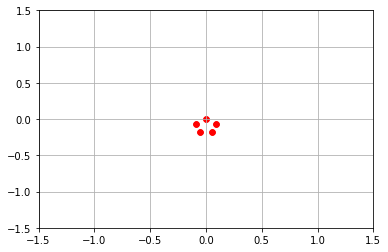

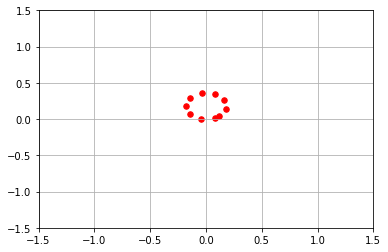

In [7]:
# plot data
p = X_train
if(settings.gpu_index >= 0):
    p = xp.asnumpy(p)

for num in range(20):
    rand_idx = int(np.random.rand() * len(X_train))
    for i in range(0,DATA_WAYPOINTS*2,2):
        plt.scatter(p[rand_idx,i], p[rand_idx,i+1],c="red",edgecolor="red",s=30,marker="o")
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.grid()
    plt.show()

In [8]:
# loss
def error_squares(truth,predict):
    # truth    [batch , x-y-th]
    # predict  [batch , x-y-th]
    w_filter = xp.tile(xp.array([1., 1., 0], dtype=xp.float32),(len(truth),1))
    truth = truth * w_filter
    predict= predict* w_filter
    error = F.sqrt(F.sum( (truth-predict)*(truth-predict),axis=1 ))
    return error

def loss_function(Y,Y_true):
    # Y      [batch, step, v-w]
    # Y_true [batch, x-y]
    batch_size = len(Y)
    num_step = len(Y[0])
    oplus = Oplus()
    y = Y.data
    yt = F.reshape(Y_true.data,(batch_size,num_step,2)).data
    # add zero-rows
    ex_dim = xp.zeros((batch_size,num_step,1),dtype=xp.float32)
    y = xp.concatenate([y,ex_dim],axis=2)
    y = y[:,:,[0,2,1]]    # v-0-w
    yt = xp.concatenate([yt,ex_dim],axis=2)    # x-y-0
    #
    oplusZ = [Variable(xp.zeros((batch_size,3), dtype = xp.float32))]
    oplusX = []
    Yt = []
    loss = Variable(xp.zeros((batch_size),dtype=xp.float32))
    for step in range(num_step):
        oplusX.append(Variable(y[:,step,:]))
        z = oplus(oplusZ[step], oplusX[step])
        oplusZ.append(z)
        Yt.append(Variable(yt[:,step,:]))
        if(step > 0):
            e = error_squares(Yt[step-1],oplusZ[step])
            loss = loss + e
    return loss
    

In [9]:
# training
def train(model,X,epoch=10,batch_size=5):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    X_iter = iterators.SerialIterator(X, batch_size)
    itr = 0
    while X_iter.epoch < epoch:
        x_batch = xp.array(X_iter.next(),dtype=xp.float32)
        x = Variable(x_batch.reshape(len(x_batch),DATA_WAYPOINTS*2))
        y = model(x)
        # print(x)
        # print(y)
        loss = loss_function(y,x)
        model.cleargrads()
        loss.backward()
        opt.update()
        print(itr)
        itr = itr + 1
        if(X_iter.is_new_epoch):
            print('epoch',X_iter.epoch,'loss',loss)
    return model

In [10]:
BATCH_SIZE = 5
EPOCH = 100
print('iteration :',DATA_SIZE / BATCH_SIZE * EPOCH)
model = Generator(DATA_WAYPOINTS,DATA_STEP)
model = train(model,X_train)
print('finished')

iteration : 20000.0
0
1
2
3
4
5
6


TypeError: 'NoneType' object is not callable

7
8
9
10
11
12
13
14
15
16
17


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


18
19
20
21
22
23
24
25
26
27
28
29


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

30
31


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


32
33
34
35
36
37
38
39
40
41


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

42
43


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


44
45
46
47
48
49
50
51
52
53


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

54
55


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


56
57
58
59
60
61
62
63
64
65


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

66
67


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


68
69
70
71
72
73
74
75
76
77


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

78
79


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


80
81
82
83
84
85
86
87
88
89


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

90
91


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


92
93
94
95
96
97
98
99
100
101


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

102
103


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


104
105
106
107
108
109
110
111
112
113


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

114
115


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


116
117
118
119
120
121
122
123
124
125


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

126
127


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


128
129
130
131
132
133
134
135
136
137


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

138
139


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


140
141
142
143
144
145
146
147
148
149


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

150
151


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


152
153
154
155
156
157
158
159
160
161


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

162


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


163
164
165
166
167
168
169
170
171
172
173
174


TypeError: 'NoneType' object is not callable

175
176
177
178
179
180
181
182
183
184
185


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


186
187
188
189
190
191
192
193
194
195
196
197


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

198
199
epoch 1 loss variable([7.0251265 2.3661096 7.5585623 6.4560733 5.7302046])
200
201
202
203
204
205
206
207
208


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


209


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

210
211
212
213
214
215
216
217
218
219
220


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


221


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

222
223
224
225
226
227
228
229
230
231
232


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


233


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

234
235
236
237
238
239
240
241
242
243
244


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


245


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

246
247
248
249
250
251
252
253
254
255
256


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


257


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

258
259
260
261
262
263
264
265
266
267
268


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


269


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

270
271
272
273
274
275
276
277
278
279
280


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


281


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

282
283
284
285
286
287
288
289
290
291
292


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


293


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

294
295
296
297
298
299
300
301
302
303
304


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


305


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

306
307
308
309
310
311
312
313
314
315
316


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


317


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

318
319
320
321
322
323
324
325
326
327
328


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


329


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

330
331
332
333
334
335
336
337
338
339
340


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


341


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

342
343
344
345
346
347
348
349
350
351
352


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


353


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

354


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

355
356
357
358
359
360
361


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
epoch 2 loss variable([ 5.6911783  2.763667   2.2043388  1.3551179 12.751934 ])
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559


TypeError: 'NoneType' object is not callable

560
561
562
563
564
565
566
567
568


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


569
570
571


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

572
573
574
575
576
577
578
579
580
581
582


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


583
584
585
586
587
588
589
590
591
592
593
594


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

595
596
597
598
599
epoch 3 loss variable([2.7842305 6.4160733 2.304831  2.1978977 6.1681767])
600
601
602
603
604


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


605
606


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

607
608
609
610
611
612
613
614
615
616


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


617
618


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

619
620
621
622
623
624
625
626
627
628


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


629
630


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

631
632
633
634
635
636
637
638
639
640


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


641
642


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

643
644
645
646
647
648
649
650
651
652


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


653
654


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

655
656
657
658
659
660
661
662
663
664


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


665
666


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

667
668
669
670
671
672
673
674
675
676


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


677
678


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

679
680
681
682
683
684
685
686
687
688


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


689
690


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

691
692
693
694
695
696
697
698
699
700


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


701
702


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

703
704
705
706
707
708
709
710
711
712


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


713
714


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

715
716
717
718
719
720
721
722
723
724


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


725
726


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

727
728
729
730
731
732
733
734
735
736


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


737
738


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

739
740
741
742
743
744
745
746
747
748


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


749
750


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

751


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

752
753
754
755
756
757
758


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


759
760
761
762
763


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

764
765
766
767
768
769
770
771
772
773
774


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


775
776
777
778
779
780
781
782
783
784
785
786


TypeError: 'NoneType' object is not callable

787
788
789
790
791
792
793
794
795
796
797
798


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

799
epoch 4 loss variable([2.4887946 9.823523  2.610995  1.3334503 3.7395782])
800
801
802
803
804
805
806
807
808
809


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


810


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

811
812
813
814
815
816
817
818
819
820
821


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


822


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

823
824
825
826
827
828
829
830
831
832
833


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


834


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

835
836
837
838
839
840
841
842
843
844
845


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


846


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

847
848
849
850
851
852
853
854
855
856
857


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


858


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

859
860
861
862
863
864
865
866
867
868
869


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


870


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

871
872
873
874
875
876
877
878
879
880
881


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


882


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

883
884
885
886
887
888
889
890
891
892
893


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


894


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

895
896
897
898
899
900
901
902
903
904
905


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


906


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

907
908
909
910
911
912
913
914
915
916
917


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


918


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

919
920
921
922
923
924
925
926
927
928
929


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


930


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

931
932
933
934
935
936
937
938
939
940
941


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


942


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

943


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

944
945
946
947
948
949
950


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


951
952
953
954
955


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

956
957
958
959
960
961
962
963
964
965
966


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


967
968
969
970
971
972
973
974
975
976
977
978


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

979
980
981
982
983
984
985
986
987
988


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


989
990


TypeError: 'NoneType' object is not callable

991
992
993
994
995
996
997
998
999
epoch 5 loss variable([6.416633  1.9464471 3.8775084 1.9799469 6.4772863])
1000


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


1001
1002


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

1003
1004
1005
1006
1007
1008
1009
1010
1011
1012


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


1013
1014


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

1015
1016
1017
1018
1019
1020
1021
1022
1023
1024


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


1025
1026


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

1027
1028
1029
1030
1031
1032
1033
1034
1035
1036


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


1037
1038


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

1039
1040
1041
1042
1043
1044
1045
1046
1047
1048


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


1049
1050


TypeError: 'NoneType' object is not callable

1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free


1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073


TypeError: 'NoneType' object is not callable


1074


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


1086


TypeError: 'NoneType' object is not callable

1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


1098


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

1136
1137
1138
1139
1140
1141
1142
1143


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


1144
1145
1146
1147


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158


Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

Exception ignored in: 'cupy.cuda.memory.PooledMemory.__dealloc__'
Traceback (most recent call last):
  File "cupy/cuda/memory.pyx", line 518, in cupy.cuda.memory.PooledMemory.free
TypeError: 'NoneType' object is not callable


1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
epoch 6 loss variable([ 5.949794  11.420698   6.431226   1.4022622  6.3751707])
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
